In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.65_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_trp')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.65_.9',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_trp')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 300.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.5, .65, .9/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 5e-25

include 'trp75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

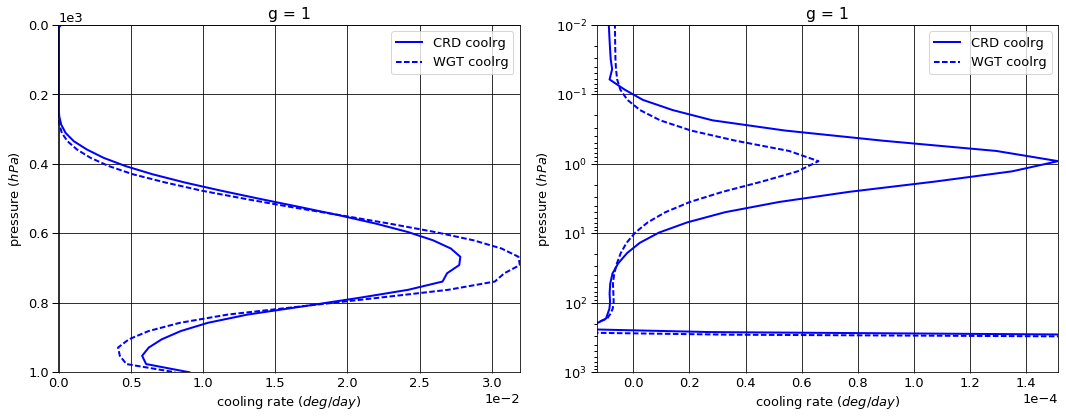

# Figure: cooling rate g-group 2

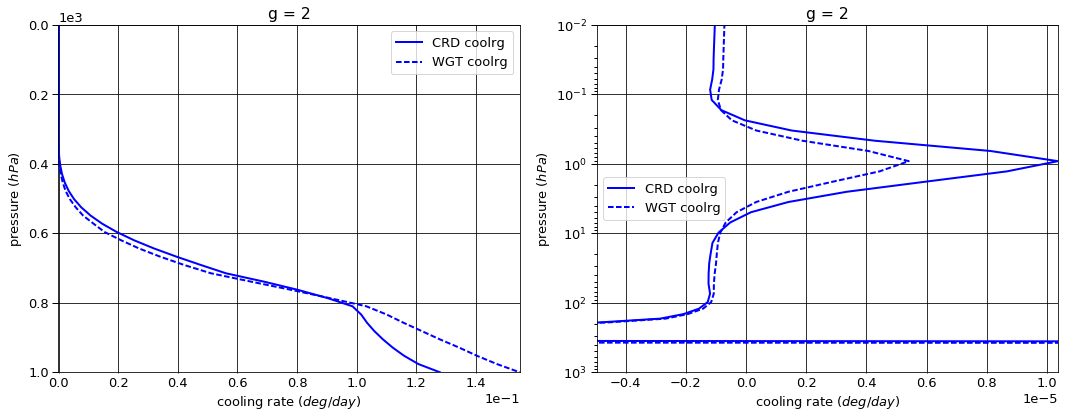

# Figure: cooling rate g-group 3

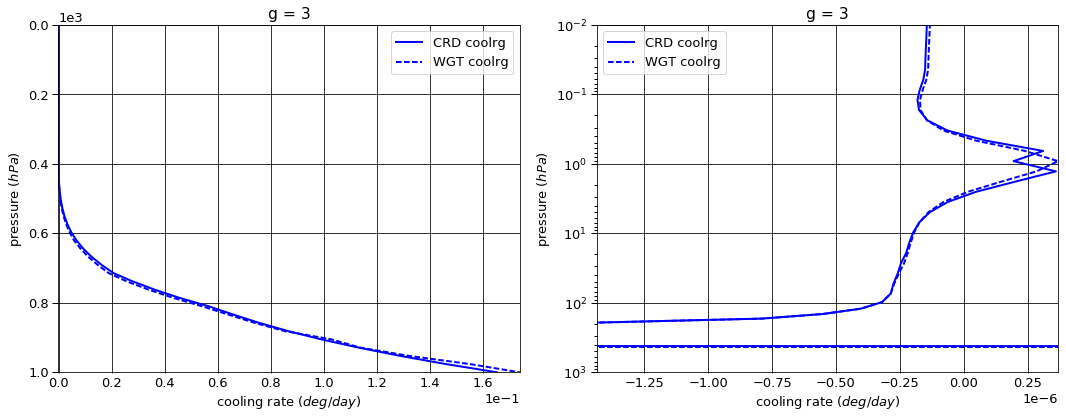

# Figure: cooling rate g-group total

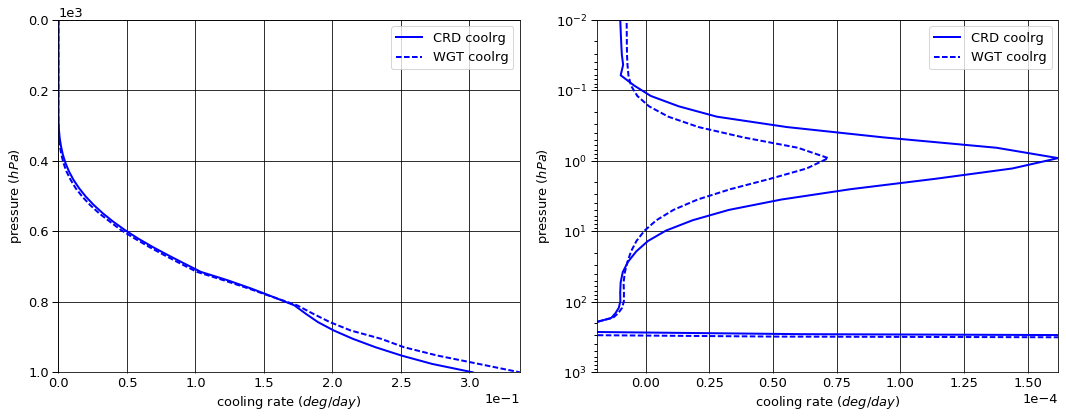

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -1.247980  0.000000  -1.247980
  1013.0   76     -1.812992  1.760405  -0.052586
2 0.0      1      -7.938409  0.000000  -7.938409
  1013.0   76     -8.819645  5.105736  -3.713909
3 0.0      1     -56.266022  0.000000 -56.266022
  1013.0   76    -56.716814  3.618486 -53.098327


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -1.245752  0.000000  -1.245752
  1013.0   76     -1.812992  1.779165  -0.033827
2 0.0      1      -7.953637  0.000000  -7.953637
  1013.0   76     -8.819645  5.410002  -3.409643
3 0.0      1     -56.276022  0.000000 -56.276022
  1013.0   76    -56.716814  3.615807 -53.101006


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.002228  0.000000  0.002228
  1013.0   76     0.000000  0.018760  0.018760
2 0.0      1     -0.015228  0.000000 -0.015228
  1013.0   76     0.000000  0.304267  0.304267
3 0.0      1     -0.010000  0.000000 -0.010000
  1013.0   76     0.000000 -0.002679 -0.002679

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.747338e-06
  1001.112500 75     9.051940e-03
2 0.000312    1     -9.213735e-07
  1001.112500 75     1.279879e-01
3 0.000312    1     -1.301684e-07
  1001.112500 75     1.653267e-01


WGT


coolrg
g pressure    layer              
1 0.000312    1     -6.746900e-06
  1001.112500 75     8.073258e-03
2 0.000312    1     -6.219022e-07
  1001.112500 75     1.547771e-01
3 0.000312    1     -1.187366e-07
  1001.112500 75     1.739106e-01


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.000438e-06
  1001.112500 75    -9.786820e-04
2 0.000312    1      2.994713e-07
  1001.112500 75     2.678911e-02
3 0.000312    1      1.143176e-08
  1001.112500 75     8.583910e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.452410,0.000000,-65.452410
1013.0,76,-67.349451,10.484627,-56.864823



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-65.475411,0.000000,-65.475411
1013.0,76,-67.349451,10.804975,-56.544475



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.023,0.000000,-0.023000
1013.0,76,0.000,0.320348,0.320348


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.302367



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000007
1001.112500,75,0.336761



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000003
1001.112500,75,0.034394


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.025750,0.027658
2,0.128833,0.132364
3,0.845417,0.839979


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,8.423988e-24
2,5.000223e-25
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,8.423988e-24,NaN,0.025750,0.027658,0.025750,0.027658,600.0
2,5.000223e-25,0.059357,0.128833,0.132364,0.154583,0.160021,600.0
3,2.367330e-27,0.004734,0.845417,0.839979,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.295989e-23  3.445805e-25  37.610616
      2     0.000312  1.073802e-25  5.166933e-27  20.782200
      3     0.000312  1.889916e-27  2.308659e-29  81.862067
2     1     0.000750  1.307437e-23  3.455562e-25  37.835727
      2     0.000750  1.089131e-25  5.188142e-27  20.992703
      3     0.000750  1.910611e-27  2.323463e-29  82.231158
3     1     0.001052  1.330966e-23  3.474105e-25  38.311055
      2     0.001052  1.120882e-25  5.229810e-27  21.432564
      3     0.001052  1.953266e-27  2.349442e-29  83.137481
4     1     0.001476  1.355258e-23  3.493092e-25  38.798236
      2     0.001476  1.154020e-25  5.272729e-27  21.886584
      3     0.001476  1.997537e-27  2.377024e-29  84.035205
5     1     0.002070  1.379998e-23  3.512385e-25  39.289475
      2     0.002070  1.188141e-25  5.316531e-27  22.348057
      3     0.002070  2.042869e-27  2.406300e-29  84.896699
6     1     0.002904  1.405183e-23  3.532149e-25  39.782667
      2     0.002904  1.223261e-25  5.361468e-27  22.815778
      3     0.002904  2.089278e-27  2.437890e-29  85.700257
7     1     0.004074  1.430816e-23  3.552633e-25  40.274814
      2     0.004074  1.259399e-25  5.407912e-27  23.288085
      3     0.004074  2.136786e-27  2.472692e-29  86.415374
8     1     0.005714  1.456916e-23  3.574202e-25  40.761984
      2     0.005714  1.296602e-25  5.456404e-27  23.762943
      3     0.005714  2.185451e-27  2.511998e-29  87.000512
9     1     0.008015  1.483473e-23  3.597352e-25  41.237896
      2     0.008015  1.334878e-25  5.507656e-27  24.236775
      3     0.008015  2.235285e-27  2.557608e-29  87.397497
10    1     0.011243  1.510494e-23  3.622802e-25  41.694088
      2     0.011243  1.374260e-25  5.562708e-27  24.704871
      3     0.011243  2.286337e-27  2.612090e-29  87.529034
11    1     0.015771  1.537983e-23  3.651562e-25  42.118486
      2     0.015771  1.414772e-25  5.623022e-27  25.160361
      3     0.015771  2.338655e-27  2.679064e-29  87.293748
12    1     0.022122  1.565941e-23  3.685059e-25  42.494319
      2     0.022122  1.456447e-25  5.690678e-27  25.593565
      3     0.022122  2.392304e-27  2.763618e-29  86.564184
13    1     0.031031  1.594466e-23  3.725359e-25  42.800335
      2     0.031031  1.499460e-25  5.768786e-27  25.992638
      3     0.031031  2.447545e-27  2.872973e-29  85.192060
14    1     0.043528  1.631564e-23  3.780137e-25  43.161506
      2     0.043528  1.556097e-25  5.874975e-27  26.486865
      3     0.043528  2.519953e-27  3.026011e-29  83.276394
15    1     0.061057  1.768876e-23  3.906313e-25  45.282485
      2     0.061057  1.771936e-25  6.171028e-27  28.713791
      3     0.061057  2.790446e-27  3.346447e-29  83.385332
16    1     0.085645  2.075924e-23  4.131370e-25  50.247828
      2     0.085645  2.290401e-25  6.786576e-27  33.748998
      3     0.085645  3.420375e-27  3.963698e-29  86.292505
17    1     0.120136  2.502831e-23  4.417765e-25  56.653786
      2     0.120136  3.088053e-25  7.650540e-27  40.363852
      3     0.120136  4.356279e-27  4.901776e-29  88.871447
18    1     0.168516  3.018859e-23  4.776796e-25  63.198417
      2     0.168516  4.160754e-25  8.745303e-27  47.577010
      3     0.168516  5.582113e-27  6.251372e-29  89.294219
19    1     0.236378  3.638984e-23  5.269255e-25  69.060684
      2     0.236378  5.591539e-25  1.018592e-26  54.894790
      3     0.236378  7.194205e-27  8.242661e-29  87.280126
20    1     0.331549  4.382037e-23  5.975117e-25  73.338093
      2     0.331549  7.488829e-25  1.217779e-26  61.495806
      3     0.331549  9.329854e-27  1.126149e-28  82.847434
21    1     0.465100  5.268875e-23  6.987954e-25  75.399387
      2     0.465100  9.986593e-25  1.501981e-26  66.489475
      3     0.465100  1.217757e-26  1.590383e-28  76.569993
22    1     0.652400  6.212812e-23  8.353532e-25  74.373473
      2     0.652400  1.289411e-24  1.888082e-26  68

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
